# Physical activity monitoring project - ML model traning



In [1]:
# Log in to your W&B account
import wandb

import random
import math
import os
import pandas as pd
import numpy as np

wandb.login()

wandb: Currently logged in as: malithjkd (springleafy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## MiniRocket + RidgeClassifier exmaple

In [2]:
import os, glob, re, random
import numpy as np
import joblib
import json
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
#from sktime.transformations.panel.minirocket import MiniRocketMultivariate

from sktime.transformations.panel.rocket import MiniRocket

In [ ]:
# Load the unvariate time series dataset
from sktime.datasets import load_unit_test

X_train, y_train = load_unit_test(split="train") 
X_test, y_test = load_unit_test(split="test") 

# Initialize the MiniRocket transformer
trf = MiniRocket(num_kernels=512) 

# learns the patterns from the training data to `create convolutional kernels.
trf.fit(X_train)

# applies these kernels to both the training and testing data, converting the raw time series into a set of features that a standard classifier can use.
X_train_tf = trf.transform(X_train) 
X_test_tf = trf.transform(X_test)

In [4]:
print(type(X_train))
print(X_train.shape, X_test.shape)
print(X_train_tf.shape, X_test_tf.shape)

<class 'pandas.core.frame.DataFrame'>
(20, 1) (22, 1)
(20, 504) (22, 504)


In [49]:
# clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf = RidgeClassifierCV(alphas=np.logspace(10, 3, 10))
clf.fit(X_train_tf, y_train)
y_pred = clf.predict(X_test_tf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.85      0.92      0.88        12
           2       0.89      0.80      0.84        10

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22



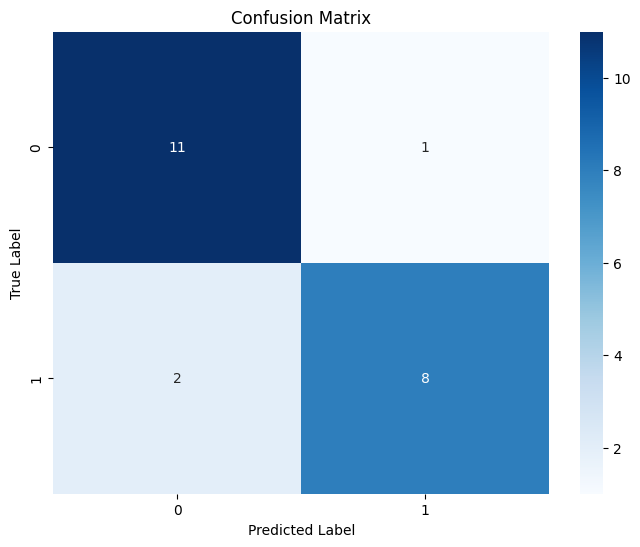

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

---

## MiniRocket Multivariate  

---

In [32]:
# Load the unvariate time series dataset
from sktime.datasets import load_basic_motions

# split data into training and testing sets
X_train, y_train = load_basic_motions(split="train",return_X_y=True)
X_test, y_test = load_basic_motions(split="test",return_X_y=True)


In [50]:
# Initialize the MiniRocketMultivariate transformer
from sktime.transformations.panel.rocket import MiniRocketMultivariate
trf = MiniRocketMultivariate(num_kernels=5)


In [51]:
# learns the patterns from the training data to `create convolutional kernels.
trf.fit(X_train)

MiniRocketMultivariate(num_kernels=5)

In [52]:
# applies these kernels to both the training and testing data, converting the raw time series into a set of features that a standard classifier can use.
X_train_tf = trf.transform(X_train)
X_test_tf = trf.transform(X_test)

In [53]:
# scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_tf_scaler = scaler.fit_transform(X_train_tf)

In [ ]:
# model training: 
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_tf_scaler, y_train)

,alphas,array([1.0000...00000000e+03])
,fit_intercept,True
,scoring,None
,cv,None
,class_weight,None
,store_cv_results,False


Test score: 1.0


In [ ]:
# load and transform the test data
X_test_tf_scaler = scaler.transform(X_test_tf)
test_score = clf.score(X_test_tf_scaler, y_test)
print("Test score:", test_score)

# make predictions
y_pred = clf.predict(X_test_tf_scaler)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   badminton       1.00      1.00      1.00        10
     running       1.00      1.00      1.00        10
    standing       1.00      1.00      1.00        10
     walking       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



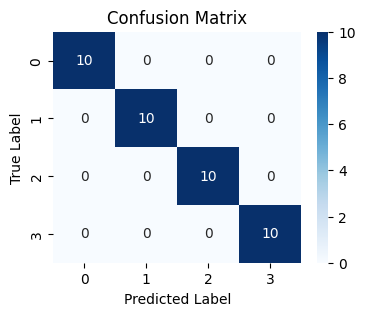

In [72]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

---

# MiniRocket + RidgeClassifier - user activity data 

In [ ]:
import glob
import re
from collections import Counter
from sklearn.model_selection import train_test_split

# Define the path to your data folder
folder_path = r"C:\Users\malit\Documents\GitHub\AI_ML_data\PAMAP2_Dataset\activity_chunks_v1"
# Get a list of all csv files for subject101
all_files = glob.glob(os.path.join(folder_path, "subject101*.csv"))

X_list = []
y_list = []

# There is 4 activity classes in the dataset, 3, 5, 6, 7
# Loop through each file and extract the activity ID and file path
for file_path in all_files:
    # 1. Parse the activity ID from the filename
    # This uses a regular expression to find the number after "activity_"
    match = re.search(r"activity_(\d+)", os.path.basename(file_path))
    if not match:
        continue # Skip files that don't match the pattern
    
    activity_id = int(match.group(1))
    
    # 2. Append the file path and activity ID to the lists
    X_list.append(file_path)
    y_list.append(activity_id)

# list unique activity IDs
unique_activities = set(y_list)
print("Unique activities:", unique_activities)

# number of samples per activity

activity_counts = Counter(y_list)
print("Activity counts:", activity_counts)

# get the minimum number of samples across all activities
min_samples = min(activity_counts.values())
print("Minimum samples per activity:", min_samples)

# create list of min_samples for each activity
balanced_y_list = []
balanced_X_list = []
for activity in unique_activities:
    # get all indices for this activity
    indices = [i for i, x in enumerate(y_list) if x == activity]
    # randomly select min_samples indices
    selected_indices = random.sample(indices, min_samples)
    # append the selected samples to the balanced lists
    for idx in selected_indices:
        balanced_y_list.append(y_list[idx])
        balanced_X_list.append(X_list[idx])

# separate the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(balanced_X_list, balanced_y_list, test_size=0.2, stratify=balanced_y_list, random_state=42)


print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("Training activity counts:", Counter(y_train))
print("Testing activity counts:", Counter(y_test))

print(X_train[:5])
print(y_train[:5])


Unique activities: {3, 5, 6, 7}
Activity counts: Counter({3: 195, 6: 169, 7: 94, 5: 64})
Minimum samples per activity: 64
Training samples: 204
Testing samples: 52
Training activity counts: Counter({5: 51, 6: 51, 7: 51, 3: 51})
Testing activity counts: Counter({6: 13, 3: 13, 5: 13, 7: 13})
['C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_5_chunk_58.csv', 'C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_6_chunk_25.csv', 'C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_5_chunk_60.csv', 'C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_7_chunk_46.csv', 'C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_5_chunk_39.csv']
[5, 6, 5, 7, 5]


In [113]:
# open csv files and load data into numpy arrays remove column 0 and 1 (timestamp and activity ID)
def load_data(file_paths):
    data_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, header=None)
        # remove column 0 and 1
        df = df.drop(columns=[0, 1])
        data_list.append(df.values)
    return np.array(data_list)

In [114]:
X_train_data = load_data(X_train)
print(X_train_data.shape)


X_test_data = load_data(X_test)
print(X_test_data.shape)


(204, 100, 43)
(52, 100, 43)


In [116]:
# --- Step 2: Transpose and Reshape for sktime ---
# We need to swap the last two axes to (n_instances, n_variables, n_timepoints)
# Original shape is (n_instances, n_timepoints, n_variables)

X_train_data_T = np.transpose(X_train_data, (0, 2, 1))
print(X_train_data_T.shape)

X_test_data_T = np.transpose(X_test_data, (0, 2, 1))
print(X_test_data.shape)

(204, 43, 100)
(52, 43, 100)


In [119]:
# Initialize the MiniRocketMultivariate transformer
from sktime.transformations.panel.rocket import MiniRocketMultivariate
trf = MiniRocketMultivariate(num_kernels=512)

# learns the patterns from the training data to `create convolutional kernels.
trf.fit(X_train_data_T)

# applies these kernels to both the training and testing data, converting the raw time series into a set of features that a standard classifier can use.
X_train_tf = trf.transform(X_train_data_T)
X_test_tf = trf.transform(X_test_data_T)



In [120]:
# scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_tf_scaler = scaler.fit_transform(X_train_tf)


In [121]:
print(X_train_tf_scaler.shape)

(204, 504)


In [122]:
# model training: 
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_tf_scaler, y_train)

,alphas,array([ 0.0... 1000. ])
,fit_intercept,True
,scoring,None
,cv,None
,class_weight,None
,store_cv_results,False


In [123]:
# load and transform the test data
X_test_tf_scaler = scaler.transform(X_test_tf)
test_score = clf.score(X_test_tf_scaler, y_test)
print("Test score:", test_score)

# make predictions
y_pred = clf.predict(X_test_tf_scaler)
print(classification_report(y_test, y_pred))

Test score: 0.25


C:\Users\malit\Documents\GitHub\AI_ML_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\malit\Documents\GitHub\AI_ML_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\malit\Documents\GitHub\AI_ML_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00        13
           7       0.25      1.00      0.40        13

    accuracy                           0.25        52
   macro avg       0.06      0.25      0.10        52
weighted avg       0.06      0.25      0.10        52



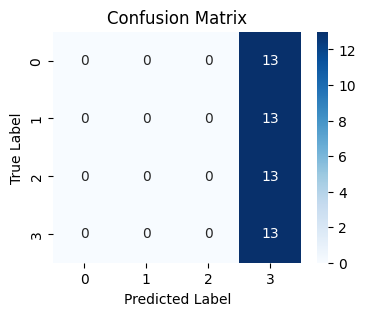

In [124]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()